In [1]:
# check if gpus available
from numpy.random import seed as rng
rng(2000)
from tensorflow import set_random_seed
set_random_seed(2000)

import tensorflow as tf; print(tf.__version__)
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
from keras import backend as K
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

# import the package dependencies
import numpy as np # number computation package
import time # for calculating runtime
import scipy.io as sio
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import scipy
print(scipy.__version__)
import scipy.stats as stat
from scipy.signal import find_peaks, hilbert

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import keras

# #
import numpy.random as rd
from spect_dB import spect_dB # my spectrogram code

import importlib
import math

# # # # # # # # # # #
t00= time.time()
%run -i 'set_params.py'

/Users/emmacreeves/anaconda3/envs/new_deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/emmacreeves/anaconda3/envs/new_deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/emmacreeves/anaconda3/envs/new_deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/emmacreeves/ana

1.0.0


Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17058941816991400782
]
1.4.1


## Define functions 

In [2]:
def target_distribution(q):
    """
    Compute the target distribution p, given soft assignements, q. The target distribtuion is generated by giving
    more weight to 'high confidence' samples - those with a higher probability of being a signed to a certain cluster. 
    This is used in the KL-divergence loss function.
    # Arguments
        q: Soft assignement probabilities - Probabilities of each sample being assigned to each cluster.
    # Input:
         2D tensor of shape [n_samples, n_features].
    # Output:
        2D tensor of shape [n_samples, n_features].
    """
    weight = q ** 2 / q.sum(0)
   # print(q.sum(0), weight.sum(1))
    return (weight.T / weight.sum(1)).T

## Set parameters

In [3]:
rng(3)
sigparams = dict()
    
#Nsamp = 10000
Ntrials = 1
#seeds_all = rd.permutation(Nsamp*Ntrials)
#seeds_all = np.reshape(seeds_all, (Nsamp,Ntrials)) 
#snrdb_list = rd.randint(15,high=30,size=Nsamp)
nclus_list = [2]#,3,4,5,6]
ndim_list = [10]#[10,15,20]

print(nF)

iex = [22,72] # example indices to save, save the TS from these
save_out = dict() # preallocate saveout dictionary (for MATLAB plotting)

90


## Load Data

In [52]:
data = []
t1 = time.time()
input_matrix = np.load(spath + 'Feb25_det_90_120_trunc049sfull_025sbuff_nfft256_3D.npy')
#irand = sio.loadmat(dpath + 'Rand_Indices')
#test_holdout = irand['Irand'][0,:]-1

print(input_matrix.shape)
Ntot = input_matrix.shape[0]

# load some seeds used before in Matlab
lb=sio.loadmat('labelseeds')
irandsub=lb['irand'][0,:]-1
ir = irandsub.shape[0]
print(irandsub.shape)

reflabels = sio.loadmat('Oct28_hand_labels')
reflabels = reflabels['hand_labels'][0,:]
iwhale = np.where(reflabels==0)[0]-1
ifish = np.where(reflabels==1)[0]-1


# # !!! for CPU # # #
rng(3)
ir = np.random.permutation(4000)
ir = ir[0:100]
iwhale = np.where(reflabels[irandsub[ir]]==0)[0]
ifish = np.where(reflabels[irandsub[ir]]==1)[0]

input_matrix = input_matrix[irandsub[ir],:,:,0] # select random subset to be comparable to simulation
Ntot = input_matrix.shape[0]

(92736, 90, 20, 3)
(10000,)


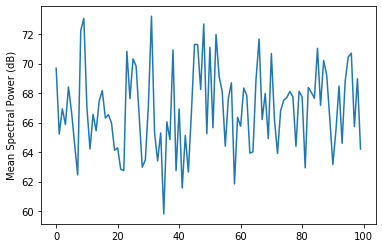

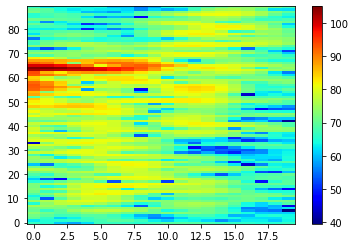

In [53]:
# # Sanity check
sumtest = np.nansum(input_matrix[:,:,:], axis=(1,2))
plt.plot(sumtest/(nF*(nL+1)))
plt.ylabel('Mean Spectral Power (dB)')
plt.show()

it = iwhale[18]
plt.imshow(input_matrix[it,:,:], aspect='auto', origin=-1,cmap='jet')
plt.colorbar()
#plt.clim((0,1))
plt.show()

In [28]:
## normalize data to max
input_matrix = input_matrix/np.max(input_matrix,axis=(1,2),keepdims=True)
    
data.append(input_matrix[:,:,:]) # only keep pressure
print(data[-1].shape)
print(time.time()-t1)

(100, 90, 20)
268.6060950756073


In [32]:
scores = dict()
scores['acc'] = []
scores['mutual_info'] = []
scores['silhouette'] = []
CAE = []
DEC_labels = []
encode_DEC = []

## Set DEC parameters
# Parameters for the  DEC finetuning
Ntot = input_matrix.shape[0]

# define percent for training data
Ntrain = np.floor(Ntot).astype(int)
Nval = np.floor(0*Ntot).astype(int)
batch_size=256                  # number of samples in each batch
tol = 0.0000001                        # tolerance threshold to stop training
updates_per = 2
nepochs = 100
maxiter = nepochs*np.floor(Ntrain/batch_size).astype(int)#47250   # number of updates to rub before halting. (~12 epochs)
update_interval = np.floor(Ntrain/batch_size/updates_per).astype(int)# Soft assignment distribution and target distributions updated evey 315 batches. 
                                   #(~2 updates/epoch)
pre_epochs = 5000
    
# # !!! CPU SPECS # #
batch_size = 32
update_interval = np.floor(Ntrain/batch_size/updates_per).astype(int)# Soft assignment distribution and target distributions updated evey 315 batches. 
                                   #(~2 updates/epoch)
maxiter = 5*np.floor(Ntrain/batch_size).astype(int)
pre_epochs = 1000

In [33]:
for M in range(Ntrials):
    print('Running model for compression with dimension ' + str(ndim_list[M]) + '.')
    #print('Running model for ' + str(nclus_list[M]) + ' clusters.')
    t0=time.time()

    import warnings

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=False)
    #for M in range(Ntrials):
    input_matrix = data[0]


    t0=time.time()
    # split the data
    rng(3)
    trainvalsplit=rd.permutation(Ntot)

    # # # train
    trainind = trainvalsplit[0:Ntrain]
    train = input_matrix[trainind,:,:, np.newaxis]
    tmin = np.min(train,axis=(0,1,2))
    tmax = np.max(train-tmin, axis=(0,1,2))
  #  train = (train-tmin)/tmax
    
    save_out['tmin'] = tmin
    save_out['tmax'] = tmax
    #train = scaler.fit_transform( input_matrix[trainind,:].reshape(Ntrain,-1) ).reshape(Ntrain,nF,nL+1,1)
    
    # # # val
    valind = trainvalsplit[Ntrain:(Ntrain+Nval)]
    val = input_matrix[valind,:,:,np.newaxis]
   # val = (val-tmin)/tmax
  #  val = scaler.transform( input_matrix[valind,:,:].reshape(Nval,-1) ).reshape(Nval, nF, nL+1,1)

    # # # test
    testind = trainvalsplit[(Ntrain+Nval):(Ntrain+2*Nval)]
    test = input_matrix[testind,:,:,np.newaxis]
  #  test = (test-tmin)/tmax
   # test = scaler.transform( input_matrix[testind,:,:].reshape(Nval,-1) ).reshape(Nval, nF, nL+1,1)

    # normalize full data
    in_norm = input_matrix[:,:,:,np.newaxis]
  #  in_norm = (in_norm-tmin)/tmax
    #scaler.transform(input_matrix.reshape(Nsamp,-1)).reshape(Nsamp, nF, nL+1, 1)


    n_clusters=2 # dummy
    from tensorflow import set_random_seed
    rng(2)
    set_random_seed(2)
    # lines to reload in case of changes & to reset model
    import DEC_CAE_256nfft
    importlib.reload(DEC_CAE_256nfft)

    from DEC_CAE_256nfft import CAE_for_DEC
    models = CAE_for_DEC(nF, nL+1, 1,ndim_list[M], n_clusters)
    ae = models[0]
    encoder = models[1]
   # ae.summary()
    #print(rd.randint(5,high=None)) # # checking randomness
    
    # # load model trained on sim # #
#     ae = keras.models.load_model('AE_sim.h5')
#     encoder = keras.models.load_model('enc_sim.h5')

#     ae.compile(optimizer='Adam',loss='mse') # compile pretrained models
#     encoder = keras.models.Model(inputs=ae.input, outputs=ae.get_layer("encoded").output)
#     encoder.compile(optimizer='Adam',loss='mse')

#     # PRETRAIN CAE
    print('Training CAE...')
    bc = (np.ceil(np.log2(np.abs(train.shape[0]/4)))).astype(int)
    t1=time.time()
    ae.fit(train, train,
                    epochs=pre_epochs,
                    batch_size=2**bc,
                    shuffle=True,
                    validation_data=(val, val),
                    verbose=0)
                    #callbacks= [TensorBoard(log_dir='/tmp/autoencoder')])
    print("{:.4} seconds.".format(time.time()-t1))
    decoded_imgs = ae.predict(in_norm)
    CAE_encoded = encoder.predict(in_norm)
    CAE_train_encoded = encoder.predict(train)
    
    CAE.append(CAE_encoded)
    

    #test_decode = ae.predict(in_norm)
    evalu = ae.evaluate(in_norm, in_norm)
    print(evalu)

    # Make DEC model
    loss = 0                           # initialize loss
    index = 0                          # initialize index to start 

    
    # # use GMM instead...
    from sklearn import mixture
    rng(3)
    g = mixture.GaussianMixture(n_components=2, covariance_type='diag')
    g.fit(CAE_train_encoded)
    labels = g.predict(CAE_train_encoded)
    labels_last = labels
    means = g.means_
    
    n_clusters=nclus_list[M]
    from tensorflow import set_random_seed
    rng(2)
    set_random_seed(2)
    import DEC_base
    importlib.reload(DEC_base)
    from DEC_base import DEC
    alpha = g.weights_ 
    #alpha = alpha/np.min(alpha)
    #alpha = np.array([2.0, 1.0])
    dec = DEC(n_clusters, alpha, ae, encoder) # uses trained model

    print('Getting initial clusters...')
#     kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=2) # run kmeans with n_clusters, run 10 initializations to ensure accuracy
#     labels = kmeans.fit_predict(CAE_train_encoded)             # get initial assignments
#     labels_last=labels
#     klabels = labels
#     means = kmeans.cluster_centers_
    
    # initialize the DEC clustering layer weights using cluster centers found initally by kmeans.                                                                         
    dec.get_layer(name='clustering').set_weights([means])#[centroids])#

    print('Fine-tuning with DEC...')
    index_array = np.arange(train.shape[0])
    #https://github.com/dsnover/Unsupervised_Machine_Learning_for_Urban_Seismic_Noise/blob/master/CAE_wDEC.ipynb
    ###############################################################################
    ### simultaneous optimization and clustering
    loss_list = np.zeros([maxiter,3])                       # Keep track of loss function during training process
    for ite in range(int(maxiter)):
        if ite % update_interval == 0:
            q,reconst  = dec.predict(train, verbose=0) # Calculate soft assignment distribtuion & CAE reconstructions
            p = target_distribution(q)                      # Update the auxiliary target distribution p       
            labels = q.argmax(1)                            # Assign labels to the embedded latent space samples

            # check stop criterion - Calculate the % of labels that changed from previous update
            warnings.simplefilter(action='ignore', category=DeprecationWarning) # # #DUE TO MY PY/NUMPY VERSIONING
            delta_label = (np.sum(labels.astype(int) != labels_last.astype(int))).astype(np.float32) /labels.shape[0]  
            labels_last = np.copy(labels)                   # Generate copy of labels for future updates   
            loss= np.round(loss, 5)                         # Round the loss 

           # print('Iter %d' % ite)
           # print('Loss: {}'.format(loss))

            if ite > 0 and delta_label < tol:               # Break training if loss reaches the tolerance threshhold
                print('delta_label ', delta_label, '< tol ', tol)
                break
        
        idx = index_array[index * batch_size: min((index+1) * batch_size, train.shape[0])]
        loss = dec.train_on_batch(x=train[idx,:,:,:], y=[p[idx], train[idx,:,:,:]])
        index = index + 1 if (index + 1) * batch_size <= train.shape[0] else 0

    #dec.save(fname + str(ndim) + 'd_' + str(n_clusters) + 'c.hdf5')#.format(date_name))

    toc = time.time()
    print('Deep Embedded Clustering Computation Time : {0:4.1f} minutes'.format((toc-t0)/60))
    rng(2)
    set_random_seed(2)
    
    q,reconst = dec.predict(in_norm) 
    decpred = encoder.predict(in_norm)
    encode_DEC.append(decpred)
    DEC_labels.append(q.argmax(1))
    
    if M==0:
        dec.summary()
    
  #  a1 = np.sum(DEC_labels[M]==true_labels[0])/Nsamp
  #  a2 = np.sum(np.abs(1-DEC_labels[M])==true_labels[0])/Nsamp
    
  #  acc = np.round(100*np.maximum(a1,a2),1)
#    mi = metrics.normalized_mutual_info_score(true_labels[0], DEC_labels[M])
    if len(np.unique(DEC_labels[M]))>1:
        sil = metrics.silhouette_score(decpred, DEC_labels[M], metric='euclidean')
    else:
        sil = np.nan
    
 #   scores['acc'].append(acc)
#    scores['mutual_info'].append(mi)
    scores['silhouette'].append(sil)
  #  

 #   print('Accuracy was ' + str(acc) + '%.')
  #  print('Mutual info: ' + str(mi) + '.')
    print('Silhouette score: ' + str(sil) + '.')

Running model for compression with dimension 10.
Training CAE...
114.2 seconds.
100/100 [==============================] - 0s 703us/step
0.0048945992812514305
Getting initial clusters...
Fine-tuning with DEC...
delta_label  0.0 < tol  1e-07
Deep Embedded Clustering Computation Time :  2.0 minutes
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 90, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 45, 10, 8)    80          input[0][0]                      
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 44, 10, 8)    136         conv2d_8[0][0]                   
_________

<class 'numpy.ndarray'> <class 'list'>


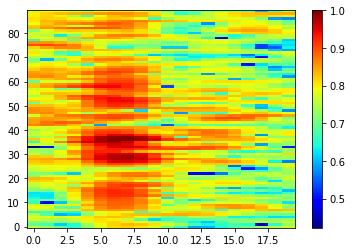

(100, 90, 20, 1)


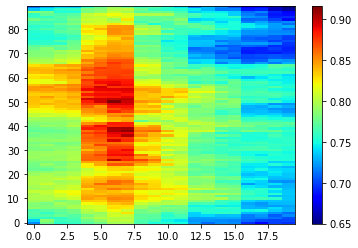

In [35]:
print(type(g.weights_/np.min(g.weights_)),type([2.0,1.0]))
labels2 = g.predict(CAE_encoded)
it = 42
input_matrix = data[0]
plt.imshow(in_norm[it,:,:,0], aspect='auto', origin=-1,cmap='jet')
plt.colorbar()
#plt.clim((0,1))
plt.show()

print(reconst.shape)

plt.imshow(decoded_imgs[it,:,:,0], aspect='auto',origin=-1,cmap='jet')
plt.colorbar()
plt.show()


In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=20)
#Yd = tsne.fit_transform(CAE_train_encoded)
Ycae = tsne.fit_transform(CAE_encoded)
Ydec = tsne.fit_transform(encode_DEC[-1])

In [46]:
# # # SAVE RELEVANT RESULTS
savename = 'Nov14_normrealdata_256nfft_5000epochs_100epochs_10dim_2c_gmmalpha29.mat'
#save_out['seeds'] = seeds_all[iex,0]
save_out['spect_inputs'] = in_norm#[iex]
save_out['CAE_recon'] = decoded_imgs#[iex]
save_out['DEC_recon'] = reconst#[iex]
save_out['encoded_DEC'] = decpred
#save_out['true_labels'] = true_labels[-1]
#save_out['agglom_CAE'] = h_labels[-1]
#save_out['kmeans_CAE'] = y_labels[-1]
save_out['DEC_labels'] = DEC_labels[-1]
save_out['gmm_cae_labels'] = labels2
save_out['tsne_CAE'] = Ycae
save_out['tsne_DEC'] = Ydec
#save_out['physical'] = pfeatures
#save_out['snr'] = snrdb_list

if False: # save
    sio.savemat(savename,save_out)

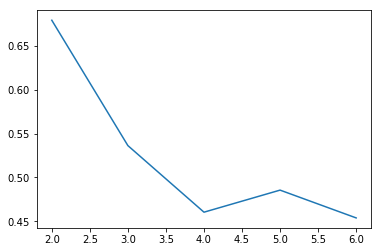

In [29]:
savename_tune = 'Oct28_256nfft_5000epochs_20epochs_realdata_ndim10_nclust'
plt.plot(nclus_list, scores['silhouette'])
plt.show()
scores['nclus']= nclus_list
scores['ndim'] = ndim_list

if False: # save
    sio.savemat(savename_tune,scores)

In [55]:
print(len(DEC_labels))
#print(DEC_labels[-1].shape)
refcol = ['b','r','m','k','g','y']
truecolors = [refcol[reflabels[irandsub[i]]] for i in range(Ntot)]
caecolors = [refcol[labels2[i]] for i in range(Ntot)]
deccolors = [refcol[DEC_labels[-1][j]] for j in range(Ntot)]
#deccolors = [refcol[y_labels[0][j].astype(int)] for j in range(int(Nsamp))]

plt.scatter(Ydec[:,0], Ydec[:,1],c=truecolors)
plt.show()

plt.scatter(Ycae[:,0], Ycae[:,1],c=deccolors)
plt.show()

print(len(ir))

1


TypeError: only integer scalar arrays can be converted to a scalar index

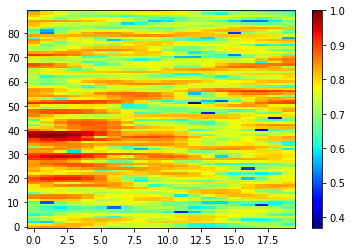

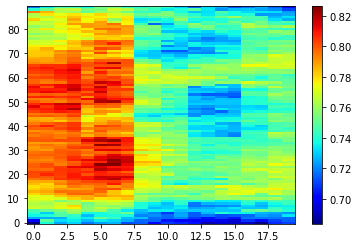

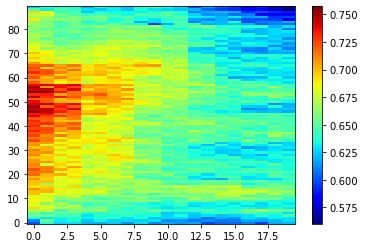

In [43]:
it = 21
input_matrix = data[0]
plt.imshow(in_norm[it,:,:,0], aspect='auto', origin=-1,cmap='jet')
plt.colorbar()
#plt.clim((0,1))
plt.show()

plt.imshow(decoded_imgs[it,:,:,0], aspect='auto',origin=-1,cmap='jet')
#plt.clim((0,1))
plt.colorbar()
plt.show()

plt.imshow(reconst[it,:,:,0], aspect='auto',origin=-1,cmap='jet')
#plt.clim((0,1))
plt.colorbar()
plt.show()
